# GHZ State Preparation Fidelity

Here, we assess the quantum state fidelity for GHZ preparation accross a suite of IBM Quantum 27-qubit Falcon chips. A decay in fidelity is observed, dropping to near-zero after 21 qubits since this is the longest connected path of qubits given the heavy-hex topology.

In [26]:
import os
import json
import numpy as np
from qiskit.providers.ibmq.runtime import RuntimeEncoder, RuntimeDecoder
from postprocessing.process_GHZ_experiments import process_GHZ
from symmer.symplectic import QuantumState

In [27]:
qem_directory =  os.getcwd()
ghz_data_dir = os.path.join(qem_directory, 'data/GHZ_preparation/')

def get_data(system):
    RD = RuntimeDecoder()
    with open(f'{ghz_data_dir}{system}_GHZ.json', 'r') as f:
        data_dict = json.load(f)
    data = RD.decode(data_dict)
    return data

In [28]:
systems = [
    'ibmq_kolkata',
    'ibmq_mumbai',
    'ibm_hanoi',
    'ibm_cairo',
    'ibm_auckland',
    'ibm_geneva',
    'ibmq_toronto',
    'ibmq_montreal'
    ]

In [49]:
final_data = {}
# store number of CNOTs against qubits
num_CNOTS_per_system=[]
for system in systems:
    print(system)
    GHZ_data_out = get_data(system)
    # number of CNOTS
    num_CNOTS = []
    for i in range(1, len(GHZ_data_out)+1):
        num_CNOTS.append(GHZ_data_out[str(i)]['circuit'].num_nonlocal_gates())
    num_CNOTS_per_system.append(num_CNOTS)
    # bootstrap the GHZ measurement data
    raw_out = process_GHZ(GHZ_data_out, 100, 32_000, use='RAW')
    mem_out = process_GHZ(GHZ_data_out, 100, 32_000, use='MEM')
    final_data[system] = {'RAW':raw_out, 'MEM':mem_out}
    
num_CNOTS_per_system = np.asarray(num_CNOTS_per_system)

ibmq_kolkata
ibmq_mumbai
ibm_hanoi
ibm_cairo
ibm_auckland
ibm_geneva
ibmq_toronto
ibmq_montreal


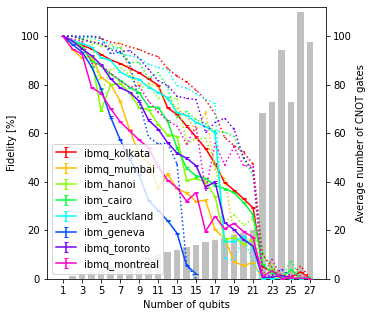

In [168]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 8  # previous pdf hatch linewidth

fig, axis = plt.subplots(figsize=(5,5))

for index, system in enumerate(systems):
    c = plt.cm.hsv(index/len(systems))
    out = final_data[system]
    raw_avg = [np.mean(out['RAW'][i])*100 for i in out['RAW']]
    raw_std = [np.std(out['RAW'][i])*100 for i in out['RAW']]
    mem_avg = [np.mean(out['MEM'][i])*100 for i in out['MEM']]
    mem_std = [np.std(out['MEM'][i])*100 for i in out['MEM']]
    x=np.arange(1, len(raw_avg)+1)
    
    axis.errorbar(x=x, y=raw_avg, yerr=raw_std, capsize=2, color=c, label=system, lw=1.5)
    axis.errorbar(x=x, y=mem_avg, yerr=mem_std, capsize=0, ls=':', color=c, lw=1.5)

cnot_axis = axis.twinx()
cnot_axis.bar(
    x, np.mean(num_CNOTS_per_system, axis=0), 
    alpha=1, color='silver',width=0.7)
cnot_axis.set_ylabel('Average number of CNOT gates')
cnot_axis.get_shared_y_axes().join(axis, cnot_axis)
axis.set_zorder(cnot_axis.get_zorder()+1)
axis.set_frame_on(False)
    
axis.set_ylabel('Fidelity [%]')
axis.set_xlabel('Number of qubits')
axis.set_xticks(np.arange(1, 28, 2))
axis.legend(ncol=1, loc='lower left')
axis.set_ylim([0,112])
#axis.fill_betweenx([0,100],22,27,alpha=0.2, color='red')

fig.savefig('plots/GHZ_benchmark.png', dpi=300, bbox_inches='tight')

# Bonus: MEM versus RAW measurement distributions

In [24]:
GHZ_data_out = get_data('ibmq_kolkata')

n_qubits = 21
offset = 0.25
threshold = 0.01

ideal = {'0'*n_qubits:0.5, '1'*n_qubits:0.5}
raw = GHZ_data_out[str(n_qubits)]['RAW']
mem = GHZ_data_out[str(n_qubits)]['MEM']

bitstrings = list(map(lambda x:np.binary_repr(x, n_qubits), range(2**n_qubits)))

x=[]
y_RAW = []
y_MEM = []
y_IDEAL = []

for bs in bitstrings:
    r = raw.get(bs, 0)
    m = mem.get(bs, 0)
    i = ideal.get(bs, 0)
    
    if any([r>threshold, m>threshold, i>threshold]):
        x.append(bs)
        y_RAW.append(r)
        y_MEM.append(m)
        y_IDEAL.append(i)
        
y_RAW = np.asarray(y_RAW)
y_MEM = np.asarray(y_MEM)
y_IDEAL = np.asarray(y_IDEAL)
x_loc = np.arange(len(x))
order = np.argsort(y_RAW)

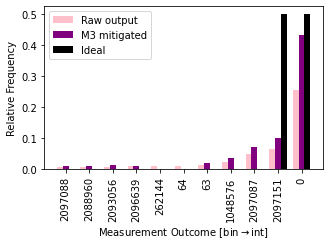

In [25]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(x_loc-offset, y_RAW[order], width=offset, label='Raw output', color='pink')
ax.bar(x_loc, y_MEM[order], width=offset, label='M3 mitigated', color='purple')
ax.bar(x_loc+offset, y_IDEAL[order], width=offset, label='Ideal', color='black')

#ax.set_yscale('log')
ax.legend(ncol=1, loc='upper left')
xtick_labels=list(map(lambda x:int(x,2), x))
ax.set_xticks(x_loc, [xtick_labels[i] for i in order], rotation=90)
ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Measurement Outcome [bin$\\rightarrow$int]')

fig.savefig('21-qubit_hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
format(np.mean(final_data['ibmq_kolkata']['MEM']['21'])*100, '.1f')

('47.5', 29.3)